# Randon Forest Model wwith TF-IDF and Bag of words

In [63]:
# file path exist
import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string


# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.ensemble import RandomForestClassifier

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [6]:
# For non English data
if not path.exists('Eng-Hin-data/hindi-anot-shuffled-translated.csv'):
    p_data = pd.read_csv("Eng-Hin-data/hindi-anot-shuffled.csv")
    #data =  data.drop('Strength',1)
    translator = Translator()
    col_one_list = p_data['Text'].tolist()
    len(col_one_list)
    result = []
    for i  in range(len(col_one_list)):
        try:
            trans = translator.translate(col_one_list[i], dest='en')
            result.append(trans.text)
        except:
                result.append(col_one_list[i])
    p_data['Text'] = result
    p_data.to_csv('Eng-Hin-data/hindi-anot-shuffled-translated.csv', index=False)
    df = pd.read_csv('Eng-Hin-data/hindi-anot-shuffled-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df
    print("Not Exist")
else:
    print("Exist")
    df = pd.read_csv('Eng-Hin-data/hindi-anot-shuffled-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df

Exist


### Class count

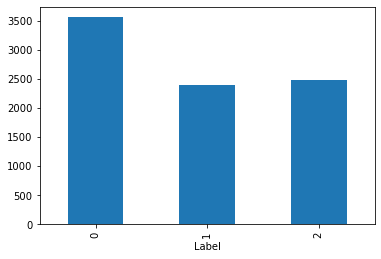

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [8]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

### Data Preprocessing

In [9]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [16]:
#Removing punctuations
data['Text'] = data['Text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [17]:
#Remove Emoji
def RemoveEmoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

data['Text'] = data['Text'].apply(lambda x: RemoveEmoji(x))

In [18]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [19]:
data.shape

(8438, 2)

In [24]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [25]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [26]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [29]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [31]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [32]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [33]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [35]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(9)

,Text_Final,tokens,Label,0,1,2,Category_id
0,cricketmann see starting earlier,"[cricketmann, see, starting, earlier]",0,1,0,0,0
1,jumaat kareem muslim brother around world alha...,"[jumaat, kareem, muslim, brother, around, worl...",1,0,1,0,1
2,thorpe becomes england head coach pakistan t20...,"[thorpe, becomes, england, head, coach, pakist...",0,1,0,0,0
3,parzevil plymouth cricket three transmission,"[parzevil, plymouth, cricket, three, transmiss...",0,1,0,0,0
4,jungkook didnt get caught eating food ramadan ...,"[jungkook, didnt, get, caught, eating, food, r...",1,0,1,0,1
5,mystic24g joyantakarmoker hate hindu come vers...,"[mystic24g, joyantakarmoker, hate, hindu, come...",2,0,0,1,2
6,sakibulhoque8 imrankhanpti terrorist muslim,"[sakibulhoque8, imrankhanpti, terrorist, muslim]",2,0,0,1,2
7,aatishtaseer tavleensingh ajenglish jehadi vie...,"[aatishtaseer, tavleensingh, ajenglish, jehadi...",2,0,0,1,2
8,sairashahhalim pbhushan1 end islamic terrorism,"[sairashahhalim, pbhushan1, end, islamic, terr...",2,0,0,1,2


In [44]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# RFM - TFIDF

In [49]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Label
features.shape

(8438, 15297)

In [68]:
# Spliting data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.20, random_state=42)

In [69]:
# Generate model
model1 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
clf1 = model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

### RFM - Showing some prediction

In [70]:
# This is OAG
print(clf1.predict(vectorizer.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['0']


In [71]:
# This is NAG 
print(clf1.predict(vectorizer.transform(["i am micro investor, need advise on adding stocks on monthly basis !"])))

['0']


In [72]:
# This is CAG
print(clf1.predict(vectorizer.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['0']


### RFM - Displaying false-positive rate (FPR) and true positive rate (TPR)

Random Forest Method


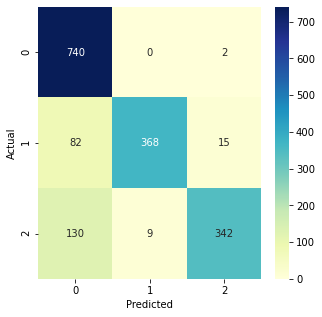

In [73]:
# confusion matrix
print("Random Forest Method")
conf_mat = confusion_matrix(y_test, y_pred1)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [74]:
results1 = confusion_matrix(y_test, y_pred1)
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred1))
print ('Report : ')
print (classification_report(y_test, y_pred1))

Confusion Matrix :
[[740   0   2]
 [ 82 368  15]
 [130   9 342]]
Accuracy Score : 0.8590047393364929
Report : 
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       742
           1       0.98      0.79      0.87       465
           2       0.95      0.71      0.81       481

    accuracy                           0.86      1688
   macro avg       0.90      0.83      0.85      1688
weighted avg       0.88      0.86      0.86      1688



### RFM K-fold

In [67]:
import random
# Creating model
model1 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)

# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model1, features, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Random Forest with BOW: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )



Random Forest with BOW: 
1 0.8317535545023697
2 0.8649289099526066
3 0.8684834123222749
4 0.8329383886255924
5 0.8424170616113744
6 0.8578199052132701
7 0.8376777251184834
8 0.8210900473933649
9 0.8600237247924081
10 0.830367734282325
 Average Accuracy : 0.8447500463814069


# RFM - BOW

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features3 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.Label
features3.shape

(8438, 16460)

In [98]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features3, labels, data.index, test_size=0.10, random_state=42)

In [99]:
# generate Linear SVM model
model3 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=52)
clf3 = model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

### RFM - BOW - Showing some prediction

In [100]:
# OAG
print(clf3.predict(count_vect.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['0']


In [101]:
# NAG
print(clf3.predict(count_vect.transform(["i am micro investor, need advise on adding stocks on monthly basis !"])))

['0']


In [102]:
# CAG
print(clf3.predict(count_vect.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['0']


In [103]:
# 2
print(clf3.predict(count_vect.transform(["Muslim asshole !"])))

['0']


In [104]:
# 1
print(clf3.predict(count_vect.transform(["Islam is a awesome, I have a muslim friend"])))

['2']


In [105]:
print(clf3.predict(count_vect.transform(["Blacks are asshole"])))

['0']


###  RFM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     RFM - BOW


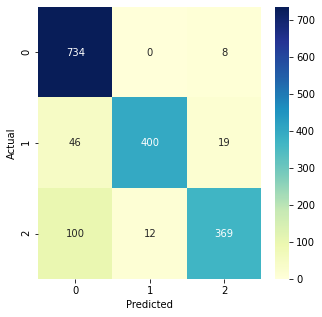

In [82]:
from sklearn.metrics import confusion_matrix
print("                     RFM - BOW")
conf_mat = confusion_matrix(y_test, y_pred3)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [83]:
results3 = confusion_matrix(y_test, y_pred3)
print ('Confusion Matrix :')
print(results3) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred3))
print ('Report : ')
print (classification_report(y_test, y_pred3))

Confusion Matrix :
[[734   0   8]
 [ 46 400  19]
 [100  12 369]]
Accuracy Score : 0.8904028436018957
Report : 
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       742
           1       0.97      0.86      0.91       465
           2       0.93      0.77      0.84       481

    accuracy                           0.89      1688
   macro avg       0.91      0.87      0.89      1688
weighted avg       0.90      0.89      0.89      1688



### RFM with BOW Kfold

In [84]:
# model
model3 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=32)

# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model3, features3, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Random Forest with BOW: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )

Random Forest with BOW: 
1 0.9028436018957346
2 0.8755924170616114
3 0.8672985781990521
4 0.8684834123222749
5 0.8720379146919431
6 0.8874407582938388
7 0.8578199052132701
8 0.8921800947867299
9 0.8754448398576512
10 0.8801897983392646
 Average Accuracy : 0.877933132066137
